In [1]:
"""
Pure CTGAN Implementation - Direct use of CTGAN without SDV wrapper.
Provides maximum control and performance for synthetic data generation.
┌────────────┐     ┌────────────┐      ┌──────────────┐      ┌──────────────┐      ┌──────────────┐
│  Start     │ →→→ │ Load Seed  │ →→→  │ Preprocess   │ →→→  │  Train CTGAN │ →→→  │ Generate     │
│            │     │ Data (CSV) │      │ Data         │      │  Model       │      │ Synthetic    │
└────────────┘     └────────────┘      └──────────────┘      └──────────────┘      │ Data         │
                                                                                   └──────┬───────┘
                                                                                          ↓
                                                                               ┌──────────────┐
                                                                               │ Save to CSV  │
                                                                               └──────────────┘

"""

'\nPure CTGAN Implementation - Direct use of CTGAN without SDV wrapper.\nProvides maximum control and performance for synthetic data generation.\n┌────────────┐     ┌────────────┐      ┌──────────────┐      ┌──────────────┐      ┌──────────────┐\n│  Start     │ →→→ │ Load Seed  │ →→→  │ Preprocess   │ →→→  │  Train CTGAN │ →→→  │ Generate     │\n│            │     │ Data (CSV) │      │ Data         │      │  Model       │      │ Synthetic    │\n└────────────┘     └────────────┘      └──────────────┘      └──────────────┘      │ Data         │\n                                                                                   └──────┬───────┘\n                                                                                          ↓\n                                                                               ┌──────────────┐\n                                                                               │ Save to CSV  │\n                                                              

<a id = 'Index:'></a>

# Table of Contents


- [Part 1.1 - Synthetic Data Generation - Classes Define](#pa11ne)
- [Part 1.2 - Synthetic Data Generation - Execution](#p12ion)
- [Part 3 - Data Exploratory Analysis](#3ysis)
- [End](#end)

In [2]:
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from pathlib import Path
from typing import List, Dict, Any, Tuple, Optional, Union
from dataclasses import dataclass, field
from contextlib import contextmanager
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer
import logging
import pickle
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Try to import the original CTGAN - fallback to our implementation if not available
try:
    from ctgan import CTGAN
    CTGAN_AVAILABLE = True
except ImportError:
    CTGAN_AVAILABLE = False
    print("⚠️ Original CTGAN not found. Using built-in implementation.")

warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
# Define the foler path
MODELS_FOLDER = '../models'
DATA_FOLDER = '../data'
LOGS_FOLDER = '../logs'
CONFIG_FOLDER = '../config'
SEED_FILE = 'final_agile_seed.csv'
DATA_FILE = 'synthetic_ISBSG2016R1_1_agile_ctgan_generated.csv'
MODEL_FILE = 'pure_ctgan_model_data_gen.pkl'


# Training constants
DEFAULT_EPOCHS = 150
DEFAULT_BATCH_SIZE = 64
DEFAULT_NUM_SAMPLES = 10000
DEFAULT_EMBEDDING_DIM = 128
DEFAULT_GENERATOR_DIM = (256, 256)
DEFAULT_DISCRIMINATOR_DIM = (256, 256)
DEFAULT_PAC = 1
DEFAULT_GENERATOR_LR = 2e-4
DEFAULT_DISCRIMINATOR_LR = 2e-4
DEFAULT_BETA1 = 0.5
DEFAULT_BETA2 = 0.999
DEFAULT_L2_PENALTY = 1e-6
DEFAULT_LAMBDA_GP = 10.0
DEFAULT_CATEGORICAL_THRESHOLD = 20

# Performance constants
DEFAULT_MIXED_PRECISION = False
DEFAULT_NUM_WORKERS = 0
DEFAULT_PIN_MEMORY = True
DEFAULT_GRADIENT_ACCUMULATION_STEPS = 1

# Validation constants
STATISTICAL_TOLERANCE_MEAN = 0.2  # 20% tolerance for mean differences
STATISTICAL_TOLERANCE_STD = 0.3   # 30% tolerance for std differences
DISTRIBUTION_OVERLAP_THRESHOLD = 0.8  # 80% category overlap threshold
OVERALL_QUALITY_THRESHOLD = 0.7   # 70% threshold for overall quality

# Data processing constants
MISSING_VALUE_TOKEN = "__MISSING__"
FEATURE_RANGE_MIN = -1
FEATURE_RANGE_MAX = 1
CLIP_EPSILON = 1e-8

# Logging constants
LOG_EPOCH_INTERVAL = 25
TRAINING_HISTORY_MIN_EPOCHS = 10

# Display constants
MAX_SAMPLE_COLUMNS_DISPLAY = 5
MAX_CATEGORICAL_COLUMNS_DISPLAY = 3
MAX_ISSUES_DISPLAY = 3

[Back to top](#Index:)

<a id='part11'></a>

## Part 1.1 - Synthetic Data Generation - Classes Define

In [4]:
@dataclass
class PureCTGANConfig:
    """Configuration for pure CTGAN implementation."""
    
    # File paths
    seed_file: str = SEED_FILE
    data_folder: Path = field(default_factory=lambda: Path(DATA_FOLDER))
    config_folder: Path = field(default_factory=lambda: Path(CONFIG_FOLDER))
    
    # CTGAN Architecture
    embedding_dim: int = DEFAULT_EMBEDDING_DIM
    generator_dim: Tuple[int, ...] = DEFAULT_GENERATOR_DIM
    discriminator_dim: Tuple[int, ...] = DEFAULT_DISCRIMINATOR_DIM
    
    # Training parameters
    epochs: int = DEFAULT_EPOCHS
    batch_size: int = DEFAULT_BATCH_SIZE
    generator_lr: float = DEFAULT_GENERATOR_LR
    discriminator_lr: float = DEFAULT_DISCRIMINATOR_LR
    beta1: float = DEFAULT_BETA1
    beta2: float = DEFAULT_BETA2
    l2_penalty: float = DEFAULT_L2_PENALTY
    
    # CTGAN specific
    pac: int = DEFAULT_PAC
    lambda_gp: float = DEFAULT_LAMBDA_GP
    
    # Data processing
    categorical_columns: List[str] = field(default_factory=list)
    discrete_columns: List[str] = field(default_factory=list)
    categorical_threshold: int = DEFAULT_CATEGORICAL_THRESHOLD
    
    # Generation
    num_samples: int = DEFAULT_NUM_SAMPLES
    
    # Hardware
    device: str = "auto"
    
    # Output
    output_filename: str = DATA_FILE
    model_filename: str = MODEL_FILE
    
    # Performance optimizations
    gradient_accumulation_steps: int = DEFAULT_GRADIENT_ACCUMULATION_STEPS
    mixed_precision: bool = DEFAULT_MIXED_PRECISION
    num_workers: int = DEFAULT_NUM_WORKERS
    pin_memory: bool = DEFAULT_PIN_MEMORY
    
    def __post_init__(self):
        """Initialize paths and device."""
        self.data_folder = Path(self.data_folder)
        self.config_folder = Path(self.config_folder)
        self._ensure_directories()
        
        if self.device == "auto":
            self.device = "cuda" if torch.cuda.is_available() else "cpu"
    
    def _ensure_directories(self):
        """Create necessary directories."""
        self.data_folder.mkdir(parents=True, exist_ok=True)
        self.config_folder.mkdir(parents=True, exist_ok=True)


class DataTransformer:
    """Optimized data transformer for CTGAN preprocessing."""
    
    def __init__(self, categorical_columns: List[str] = None, 
                 discrete_columns: List[str] = None,
                 categorical_threshold: int = DEFAULT_CATEGORICAL_THRESHOLD):
        self.categorical_columns = categorical_columns or []
        self.discrete_columns = discrete_columns or []
        self.categorical_threshold = categorical_threshold
        self.label_encoders = {}
        self.scalers = {}
        self.column_info = {}
        self.fitted = False
        self._output_dimensions = 0
    
    def fit(self, data: pd.DataFrame) -> 'DataTransformer':
        """Fit transformers to the data with optimized processing."""
        self.column_info = {}
        total_dims = 0
        
        # Auto-detect columns if not specified
        if not self.categorical_columns and not self.discrete_columns:
            detected = self.auto_detect_columns(data)
            self.categorical_columns = detected['categorical']
            self.discrete_columns = detected['discrete']
        
        for column in data.columns:
            info = {'name': column}
            col_data = data[column]
            
            if column in self.categorical_columns or col_data.dtype == 'object':
                # Categorical column processing
                info['type'] = 'categorical'
                
                # Handle missing values and convert all to strings for consistent encoding
                values_with_missing = col_data.fillna(MISSING_VALUE_TOKEN)
                
                # Convert all values to strings to handle mixed types (bool, str, etc.)
                string_values = values_with_missing.astype(str)
                
                # Get unique values
                unique_vals = string_values.unique()
                le = LabelEncoder()
                le.fit(unique_vals)
                
                self.label_encoders[column] = le
                info['num_categories'] = len(le.classes_)
                info['categories'] = le.classes_.tolist()
                total_dims += info['num_categories']
                
            elif column in self.discrete_columns:
                # Discrete numerical column
                info['type'] = 'discrete'
                # Handle potential non-numeric values by converting to numeric
                numeric_data = pd.to_numeric(col_data, errors='coerce')
                info['min'] = float(numeric_data.min())
                info['max'] = float(numeric_data.max())
                info['range'] = info['max'] - info['min']
                total_dims += 1
                
            else:
                # Continuous numerical column - use MinMaxScaler for better stability
                info['type'] = 'continuous'
                # Handle potential non-numeric values by converting to numeric
                numeric_data = pd.to_numeric(col_data, errors='coerce')
                scaler = MinMaxScaler(feature_range=(FEATURE_RANGE_MIN, FEATURE_RANGE_MAX))
                scaler.fit(numeric_data.values.reshape(-1, 1))
                self.scalers[column] = scaler
                total_dims += 1
            
            self.column_info[column] = info
        
        self._output_dimensions = total_dims
        self.fitted = True
        return self
    
    def transform(self, data: pd.DataFrame) -> np.ndarray:
        """Transform data for CTGAN training with vectorized operations."""
        if not self.fitted:
            raise ValueError("Transformer must be fitted before transform")
        
        transformed_parts = []
        
        for column in data.columns:
            info = self.column_info[column]
            col_data = data[column]
            
            if info['type'] == 'categorical':
                # Vectorized categorical transformation with type conversion
                values = col_data.fillna(MISSING_VALUE_TOKEN)
                
                # Convert all values to strings to handle mixed types
                string_values = values.astype(str)
                
                # Encode using the fitted encoder
                encoded = self.label_encoders[column].transform(string_values)
                one_hot = np.eye(info['num_categories'], dtype=np.float32)[encoded]
                transformed_parts.append(one_hot)
                
            elif info['type'] == 'discrete':
                # Normalized discrete values with type conversion
                numeric_data = pd.to_numeric(col_data, errors='coerce')
                # Fill NaN values with the minimum value
                numeric_data = numeric_data.fillna(info['min'])
                normalized = (numeric_data.values - info['min']) / (info['range'] + CLIP_EPSILON)
                normalized = np.clip(normalized, FEATURE_RANGE_MIN, FEATURE_RANGE_MAX)
                transformed_parts.append(normalized.reshape(-1, 1).astype(np.float32))
                
            else:
                # Scaled continuous values with type conversion
                numeric_data = pd.to_numeric(col_data, errors='coerce')
                # Fill NaN values with 0
                numeric_data = numeric_data.fillna(0)
                scaled = self.scalers[column].transform(numeric_data.values.reshape(-1, 1))
                transformed_parts.append(scaled.astype(np.float32))
        
        return np.concatenate(transformed_parts, axis=1)
    
    def inverse_transform(self, data: np.ndarray) -> pd.DataFrame:
        """Convert transformed data back to original format with error handling."""
        if not self.fitted:
            raise ValueError("Transformer must be fitted before inverse_transform")
        
        result_data = {}
        start_idx = 0
        
        for column in self.column_info.keys():
            info = self.column_info[column]
            
            try:
                if info['type'] == 'categorical':
                    # Inverse categorical transformation
                    end_idx = start_idx + info['num_categories']
                    one_hot_data = data[:, start_idx:end_idx]
                    categories = np.argmax(one_hot_data, axis=1)
                    
                    # Handle potential out-of-bounds categories
                    categories = np.clip(categories, 0, len(info['categories']) - 1)
                    decoded = self.label_encoders[column].inverse_transform(categories)
                    
                    # Convert back from string representation if needed
                    decoded = np.where(decoded == str(MISSING_VALUE_TOKEN), np.nan, decoded)
                    decoded = np.where(decoded == MISSING_VALUE_TOKEN, np.nan, decoded)
                    
                    # Try to convert back to original data type
                    result_data[column] = decoded
                    start_idx = end_idx
                    
                elif info['type'] == 'discrete':
                    # Inverse discrete transformation with safe range handling
                    end_idx = start_idx + 1
                    normalized_data = np.clip(data[:, start_idx:end_idx].flatten(), FEATURE_RANGE_MIN, FEATURE_RANGE_MAX)
                    range_val = info['range'] if info['range'] > 0 else 1.0
                    original = normalized_data * range_val + info['min']
                    result_data[column] = np.round(original).astype(int)
                    start_idx = end_idx
                    
                else:
                    # Inverse continuous transformation
                    end_idx = start_idx + 1
                    scaled_data = np.clip(data[:, start_idx:end_idx], FEATURE_RANGE_MIN, FEATURE_RANGE_MAX)
                    original = self.scalers[column].inverse_transform(scaled_data)
                    result_data[column] = original.flatten()
                    start_idx = end_idx
                    
            except Exception as e:
                logging.warning(f"Error transforming column {column}: {e}")
                # Fill with reasonable defaults
                if info['type'] == 'categorical':
                    result_data[column] = [info['categories'][0]] * len(data)
                else:
                    result_data[column] = np.zeros(len(data))
        
        return pd.DataFrame(result_data)
    
    def _convert_back_to_original_type(self, decoded_values, column):
        """Convert decoded string values back to their original data types."""
        # Handle common boolean string representations
        result = []
        for val in decoded_values:
            if pd.isna(val):
                result.append(np.nan)
            elif str(val).lower() in ['true', '1.0', '1']:
                result.append(True)
            elif str(val).lower() in ['false', '0.0', '0']:
                result.append(False)
            elif str(val).lower() in ['nan', 'none', 'null']:
                result.append(np.nan)
            else:
                # Try to convert to number, otherwise keep as string
                try:
                    if '.' in str(val):
                        result.append(float(val))
                    else:
                        result.append(int(val))
                except (ValueError, TypeError):
                    result.append(str(val))
        
        return result
    
    def get_output_dimensions(self) -> int:
        """Get the total number of dimensions after transformation."""
        return self._output_dimensions
    
    def auto_detect_columns(self, data: pd.DataFrame) -> Dict[str, List[str]]:
        """Enhanced auto-detection with better heuristics for boolean and mixed-type columns."""
        categorical = []
        discrete = []
        
        for col in data.columns:
            col_data = data[col]
            
            # Always treat object/category columns as categorical
            if col_data.dtype == 'object' or col_data.dtype.name == 'category':
                categorical.append(col)
            
            # Handle boolean columns and mixed boolean/string columns
            elif col_data.dtype == 'bool' or self._is_boolean_like_column(col_data):
                categorical.append(col)
            
            # Handle integer columns
            elif col_data.dtype in ['int64', 'int32', 'int16', 'int8']:
                unique_vals = col_data.nunique()
                total_vals = len(col_data.dropna())
                
                # Consider it categorical if:
                # 1. Very few unique values
                # 2. Less than threshold and represents < 50% of total values
                categorical_threshold_small = 5
                categorical_ratio_threshold = 0.5
                
                if unique_vals <= categorical_threshold_small or (unique_vals <= self.categorical_threshold and unique_vals / total_vals < categorical_ratio_threshold):
                    categorical.append(col)
                else:
                    discrete.append(col)
            
            # Handle float columns that might be boolean-like
            elif col_data.dtype in ['float64', 'float32']:
                if self._is_boolean_like_column(col_data):
                    categorical.append(col)
                # If it's mostly integers (like 1.0, 2.0, etc.), treat as discrete
                elif self._is_integer_like_float(col_data):
                    unique_vals = col_data.nunique()
                    total_vals = len(col_data.dropna())
                    categorical_threshold_small = 5
                    categorical_ratio_threshold = 0.5
                    
                    if unique_vals <= categorical_threshold_small or (unique_vals <= self.categorical_threshold and unique_vals / total_vals < categorical_ratio_threshold):
                        categorical.append(col)
                    else:
                        discrete.append(col)
                # Otherwise, it's continuous (will be handled by default)
        
        return {'categorical': categorical, 'discrete': discrete}
    
    def _is_boolean_like_column(self, col_data: pd.Series) -> bool:
        """Check if a column contains boolean-like values."""
        unique_vals = set(col_data.dropna().astype(str).str.lower().unique())
        
        # Common boolean representations
        boolean_patterns = {
            'true', 'false', '1', '0', '1.0', '0.0', 
            'yes', 'no', 'y', 'n', 't', 'f'
        }
        
        # If all non-null unique values are boolean-like
        return len(unique_vals) <= 4 and unique_vals.issubset(boolean_patterns)
    
    def _is_integer_like_float(self, col_data: pd.Series) -> bool:
        """Check if float column contains mostly integer values."""
        try:
            numeric_data = pd.to_numeric(col_data, errors='coerce')
            non_null_data = numeric_data.dropna()
            
            if len(non_null_data) == 0:
                return False
            
            # Check if most values are close to integers
            integer_like = np.abs(non_null_data - np.round(non_null_data)) < 1e-10
            return integer_like.mean() > 0.8  # 80% of values are integer-like
        except:
            return False


class Generator(nn.Module):
    """Optimized CTGAN Generator with residual connections."""
    
    def __init__(self, input_dim: int, output_dim: int, generator_dim: Tuple[int, ...]):
        super(Generator, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        # Generator architecture constants
        dropout_rate = 0.1
        
        for i, dim in enumerate(generator_dim):
            layers.extend([
                nn.Linear(prev_dim, dim),
                nn.BatchNorm1d(dim),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate)
            ])
            prev_dim = dim
        
        # Output layer
        layers.extend([
            nn.Linear(prev_dim, output_dim),
            nn.Tanh()
        ])
        
        self.model = nn.Sequential(*layers)
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights for better convergence."""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    """Optimized CTGAN Discriminator with spectral normalization."""
    
    def __init__(self, input_dim: int, discriminator_dim: Tuple[int, ...], pac: int = 1):
        super(Discriminator, self).__init__()
        self.pac = pac
        
        layers = []
        prev_dim = input_dim * pac
        
        # Discriminator architecture constants
        leaky_relu_slope = 0.2
        dropout_rate = 0.3
        
        for i, dim in enumerate(discriminator_dim):
            linear = nn.Linear(prev_dim, dim)
            # Add spectral normalization for training stability
            linear = nn.utils.spectral_norm(linear)
            
            layers.extend([
                linear,
                nn.LeakyReLU(leaky_relu_slope, inplace=True),
                nn.Dropout(dropout_rate)
            ])
            prev_dim = dim
        
        # Output layer
        output_layer = nn.Linear(prev_dim, 1)
        output_layer = nn.utils.spectral_norm(output_layer)
        layers.append(output_layer)
        
        self.model = nn.Sequential(*layers)
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights for better convergence."""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        batch_size = x.size(0)
        
        # More robust packing logic
        if self.pac > 1 and batch_size >= self.pac:
            # Only apply packing if we have enough samples
            pack_size = (batch_size // self.pac) * self.pac
            if pack_size > 0:
                x_packed = x[:pack_size]  # Take only samples that fit perfectly
                x_packed = x_packed.view(-1, self.pac * x_packed.size(-1))
                return self.model(x_packed)
        
        # Fallback to no packing
        return self.model(x)


class PureCTGAN:
    """Optimized Pure CTGAN implementation."""
    
    def __init__(self, config: PureCTGANConfig):
        self.config = config
        self.logger = self._setup_logging()
        self.device = torch.device(config.device)
        
        # Enable mixed precision if requested and available
        self.use_amp = config.mixed_precision and torch.cuda.is_available()
        if self.use_amp:
            self.scaler = torch.cuda.amp.GradScaler()
        
        # Components
        self.transformer = None
        self.generator = None
        self.discriminator = None
        self.gen_optimizer = None
        self.disc_optimizer = None
        
        # Training state
        self.trained = False
        self.training_history = []
        
        self.logger.info(f"Initialized Pure CTGAN on {self.device}")
        if self.use_amp:
            self.logger.info("Mixed precision training enabled")
    
    def _setup_logging(self) -> logging.Logger:
        """Setup optimized logging configuration."""
        logger = logging.getLogger(f"{__name__}.PureCTGAN")
        logger.setLevel(logging.INFO)
        
        if not logger.handlers:
            handler = logging.StreamHandler()
            formatter = logging.Formatter(
                '%(asctime)s - %(levelname)s - %(message)s'
            )
            handler.setFormatter(formatter)
            logger.addHandler(handler)
        
        return logger
    
    @contextmanager
    def _timer(self, operation: str):
        """Context manager for timing operations."""
        import time
        start = time.time()
        self.logger.info(f"Starting {operation}...")
        try:
            yield
            elapsed = time.time() - start
            self.logger.info(f"✓ {operation} completed in {elapsed:.2f}s")
        except Exception as e:
            elapsed = time.time() - start
            self.logger.error(f"✗ {operation} failed after {elapsed:.2f}s: {e}")
            raise
    
    def fit(self, data: pd.DataFrame):
        """Train the CTGAN model with optimized pipeline."""
        with self._timer("CTGAN Training"):
            # Prepare data transformer
            self.transformer = DataTransformer(
                categorical_columns=self.config.categorical_columns,
                discrete_columns=self.config.discrete_columns,
                categorical_threshold=self.config.categorical_threshold
            )
            self.transformer.fit(data)
            
            # Transform data
            transformed_data = self.transformer.transform(data)
            data_dim = transformed_data.shape[1]
            
            self.logger.info(f"Data transformation: {data.shape} -> {transformed_data.shape}")
            self.logger.info(f"Detected column types: "
                           f"Categorical: {len(self.transformer.categorical_columns)}, "
                           f"Discrete: {len(self.transformer.discrete_columns)}, "
                           f"Continuous: {len(data.columns) - len(self.transformer.categorical_columns) - len(self.transformer.discrete_columns)}")
            
            # Initialize networks
            noise_dim = self.config.embedding_dim
            self.generator = Generator(
                noise_dim, data_dim, self.config.generator_dim
            ).to(self.device)
            
            self.discriminator = Discriminator(
                data_dim, self.config.discriminator_dim, self.config.pac
            ).to(self.device)
            
            # Initialize optimizers with better parameters
            self.gen_optimizer = optim.AdamW(
                self.generator.parameters(),
                lr=self.config.generator_lr,
                betas=(self.config.beta1, self.config.beta2),
                weight_decay=self.config.l2_penalty
            )
            
            self.disc_optimizer = optim.AdamW(
                self.discriminator.parameters(),
                lr=self.config.discriminator_lr,
                betas=(self.config.beta1, self.config.beta2),
                weight_decay=self.config.l2_penalty
            )
            
            # Prepare optimized data loader
            tensor_data = torch.FloatTensor(transformed_data).to(self.device)
            dataset = TensorDataset(tensor_data)
            dataloader = DataLoader(
                dataset, 
                batch_size=self.config.batch_size, 
                shuffle=True, 
                drop_last=True,
                num_workers=self.config.num_workers,
                pin_memory=self.config.pin_memory and torch.cuda.is_available(),
                persistent_workers=self.config.num_workers > 0
            )
            
            # Training loop
            self._train_loop(dataloader, noise_dim)
            
            self.trained = True
            self.logger.info("✓ CTGAN training completed successfully")
    
    def _train_loop(self, dataloader, noise_dim):
        """Optimized training loop with mixed precision and gradient accumulation."""
        self.generator.train()
        self.discriminator.train()
        
        # Learning rate schedulers
        lr_scheduler_eta_min = 1e-6
        
        gen_scheduler = optim.lr_scheduler.CosineAnnealingLR(
            self.gen_optimizer, T_max=self.config.epochs, eta_min=lr_scheduler_eta_min
        )
        disc_scheduler = optim.lr_scheduler.CosineAnnealingLR(
            self.disc_optimizer, T_max=self.config.epochs, eta_min=lr_scheduler_eta_min
        )
        
        for epoch in range(self.config.epochs):
            epoch_gen_loss = 0
            epoch_disc_loss = 0
            num_batches = 0
            gen_updates = 0
            
            for batch_idx, (real_data_batch,) in enumerate(dataloader):
                batch_size = real_data_batch.size(0)
                
                # Handle pac requirements more gracefully
                if self.config.pac > 1:
                    # If batch doesn't fit pac requirement, pad or adjust
                    if batch_size % self.config.pac != 0:
                        # Calculate how many samples to keep for perfect pac alignment
                        adjusted_size = (batch_size // self.config.pac) * self.config.pac
                        if adjusted_size == 0:
                            # If batch is too small, skip this batch
                            continue
                        # Trim batch to fit pac requirement
                        real_data_batch = real_data_batch[:adjusted_size]
                        batch_size = adjusted_size
                
                # Train Discriminator
                self.disc_optimizer.zero_grad()
                
                try:
                    if self.use_amp:
                        with torch.cuda.amp.autocast():
                            disc_loss = self._discriminator_step(real_data_batch, noise_dim)
                        self.scaler.scale(disc_loss).backward()
                        self.scaler.step(self.disc_optimizer)
                        self.scaler.update()
                    else:
                        disc_loss = self._discriminator_step(real_data_batch, noise_dim)
                        disc_loss.backward()
                        self.disc_optimizer.step()
                    
                    epoch_disc_loss += disc_loss.item()
                except Exception as e:
                    self.logger.warning(f"Discriminator step failed: {e}")
                    continue
                
                # Train Generator (less frequently for better stability)
                generator_train_interval = 2
                if batch_idx % generator_train_interval == 0:
                    self.gen_optimizer.zero_grad()
                    
                    try:
                        if self.use_amp:
                            with torch.cuda.amp.autocast():
                                gen_loss = self._generator_step(batch_size, noise_dim)
                            self.scaler.scale(gen_loss).backward()
                            self.scaler.step(self.gen_optimizer)
                            self.scaler.update()
                        else:
                            gen_loss = self._generator_step(batch_size, noise_dim)
                            gen_loss.backward()
                            self.gen_optimizer.step()
                        
                        epoch_gen_loss += gen_loss.item()
                        gen_updates += 1
                    except Exception as e:
                        self.logger.warning(f"Generator step failed: {e}")
                
                num_batches += 1
            
            # Handle case where no batches were processed
            if num_batches == 0:
                self.logger.warning(f"No valid batches in epoch {epoch + 1}. Adjusting batch size or pac parameter may help.")
                # Skip this epoch but continue training
                self.training_history.append({
                    'epoch': epoch + 1,
                    'generator_loss': 0.0,
                    'discriminator_loss': 0.0,
                    'gen_lr': gen_scheduler.get_last_lr()[0],
                    'disc_lr': disc_scheduler.get_last_lr()[0]
                })
                gen_scheduler.step()
                disc_scheduler.step()
                continue
            
            # Update learning rates
            gen_scheduler.step()
            disc_scheduler.step()
            
            # Log progress
            avg_gen_loss = epoch_gen_loss / max(1, gen_updates)
            avg_disc_loss = epoch_disc_loss / num_batches  # num_batches is guaranteed > 0 here
            
            self.training_history.append({
                'epoch': epoch + 1,
                'generator_loss': avg_gen_loss,
                'discriminator_loss': avg_disc_loss,
                'gen_lr': gen_scheduler.get_last_lr()[0],
                'disc_lr': disc_scheduler.get_last_lr()[0]
            })
            
            if (epoch + 1) % LOG_EPOCH_INTERVAL == 0:
                self.logger.info(
                    f"Epoch {epoch + 1:3d}/{self.config.epochs} - "
                    f"Gen: {avg_gen_loss:.4f}, Disc: {avg_disc_loss:.4f}, "
                    f"LR: {gen_scheduler.get_last_lr()[0]:.2e}"
                )
    
    def _discriminator_step(self, real_data_batch, noise_dim):
        """Single discriminator training step."""
        batch_size = real_data_batch.size(0)
        
        # Real data
        real_validity = self.discriminator(real_data_batch)
        
        # Fake data
        noise = torch.randn(batch_size, noise_dim, device=self.device)
        with torch.no_grad():
            fake_data = self.generator(noise)
        fake_validity = self.discriminator(fake_data)
        
        # Wasserstein loss with gradient penalty
        disc_loss = -torch.mean(real_validity) + torch.mean(fake_validity)
        
        # Gradient penalty
        gp = self._gradient_penalty(real_data_batch, fake_data)
        disc_loss += self.config.lambda_gp * gp
        
        return disc_loss
    
    def _generator_step(self, batch_size, noise_dim):
        """Single generator training step."""
        noise = torch.randn(batch_size, noise_dim, device=self.device)
        fake_data = self.generator(noise)
        fake_validity = self.discriminator(fake_data)
        
        gen_loss = -torch.mean(fake_validity)
        return gen_loss
    
    def _gradient_penalty(self, real_data, fake_data):
        """Optimized gradient penalty calculation."""
        batch_size = real_data.size(0)
        alpha = torch.rand(batch_size, 1, device=self.device)
        alpha = alpha.expand_as(real_data)
        
        interpolated = alpha * real_data + (1 - alpha) * fake_data
        interpolated.requires_grad_(True)
        
        interpolated_validity = self.discriminator(interpolated)
        
        gradients = torch.autograd.grad(
            outputs=interpolated_validity,
            inputs=interpolated,
            grad_outputs=torch.ones_like(interpolated_validity),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]
        
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return gradient_penalty
    
    def sample(self, num_samples: int) -> pd.DataFrame:
        """Generate synthetic samples with optimized batching."""
        if not self.trained:
            raise ValueError("Model must be trained before sampling")
        
        with self._timer(f"Generating {num_samples:,} samples"):
            self.generator.eval()
            
            synthetic_data_list = []
            generation_batch_multiplier = 2
            batch_size = min(self.config.batch_size * generation_batch_multiplier, num_samples)
            
            with torch.no_grad():
                for i in range(0, num_samples, batch_size):
                    current_batch_size = min(batch_size, num_samples - i)
                    
                    noise = torch.randn(
                        current_batch_size, self.config.embedding_dim, device=self.device
                    )
                    
                    if self.use_amp:
                        with torch.cuda.amp.autocast():
                            fake_data = self.generator(noise)
                    else:
                        fake_data = self.generator(noise)
                    
                    synthetic_data_list.append(fake_data.cpu().numpy())
            
            # Combine all batches
            synthetic_data = np.vstack(synthetic_data_list)
            
            # Inverse transform
            synthetic_df = self.transformer.inverse_transform(synthetic_data)
            
            self.logger.info(f"✓ Generated {len(synthetic_df):,} synthetic samples")
            return synthetic_df
    
    def save(self, filepath: Union[str, Path]):
        """Save the trained model with metadata."""
        if not self.trained:
            raise ValueError("Cannot save untrained model")
        
        filepath = Path(filepath)
        
        # Save the trained model with metadata
        model_version = '2.0'
        protocol_version = pickle.HIGHEST_PROTOCOL
        
        model_state = {
            'config': self.config,
            'transformer': self.transformer,
            'generator_state': self.generator.state_dict(),
            'discriminator_state': self.discriminator.state_dict(),
            'training_history': self.training_history,
            'timestamp': datetime.now().isoformat(),
            'pytorch_version': torch.__version__,
            'model_version': model_version
        }
        
        with open(filepath, 'wb') as f:
            pickle.dump(model_state, f, protocol=protocol_version)
        
        self.logger.info(f"Model saved to {filepath}")
    
    def load(self, filepath: Union[str, Path]):
        """Load a trained model with version checking."""
        filepath = Path(filepath)
        
        with open(filepath, 'rb') as f:
            model_state = pickle.load(f)
        
        # Version compatibility check
        expected_model_version = '2.0'
        default_model_version = '1.0'
        
        if model_state.get('model_version', default_model_version) != expected_model_version:
            self.logger.warning("Loading model from different version - some features may not work")
        
        self.config = model_state['config']
        self.transformer = model_state['transformer']
        self.training_history = model_state['training_history']
        
        # Reconstruct networks
        data_dim = self.transformer.get_output_dimensions()
        noise_dim = self.config.embedding_dim
        
        self.generator = Generator(
            noise_dim, data_dim, self.config.generator_dim
        ).to(self.device)
        
        self.discriminator = Discriminator(
            data_dim, self.config.discriminator_dim, self.config.pac
        ).to(self.device)
        
        # Load states
        self.generator.load_state_dict(model_state['generator_state'])
        self.discriminator.load_state_dict(model_state['discriminator_state'])
        
        self.trained = True
        self.logger.info(f"Model loaded from {filepath}")


class PureCTGANProcessor:
    """Enhanced high-level processor for Pure CTGAN workflow."""
    
    def __init__(self, config: Optional[PureCTGANConfig] = None):
        self.config = config or PureCTGANConfig()
        self.logger = self._setup_logging()
        self.model = None
    
    def _setup_logging(self) -> logging.Logger:
        logger = logging.getLogger(f"{__name__}.Processor")
        logger.setLevel(logging.INFO)
        
        if not logger.handlers:
            handler = logging.StreamHandler()
            formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
            handler.setFormatter(formatter)
            logger.addHandler(handler)
        
        return logger
    
    def load_seed_data(self) -> pd.DataFrame:
        """Load data from the specified seed file using your provided paths."""
        # Use your exact file path structure
        seed_file_path = Path(self.config.seed_file)
        
        # If it's just a filename, look in the data folder
        if not seed_file_path.is_absolute():
            seed_file_path = self.config.config_folder / self.config.seed_file
        
        # Try multiple possible locations
        possible_paths = [
            seed_file_path,  # Primary path
            Path(self.config.seed_file),  # Direct path
            self.config.config_folder / self.config.seed_file,  # Config folder
            Path.cwd() / self.config.seed_file,  # Current directory
        ]
        
        for file_path in possible_paths:
            if file_path.exists():
                try:
                    df = pd.read_csv(file_path)
                    self.logger.info(f"Loaded seed data from {file_path}")
                    self.logger.info(f"Data shape: {df.shape}")
                    self.logger.info(f"Columns: {list(df.columns)}")
                    return df
                except Exception as e:
                    self.logger.warning(f"Failed to load {file_path}: {e}")
                    continue
        
        raise FileNotFoundError(
            f"Could not find seed file '{self.config.seed_file}' in any of these locations: "
            f"{[str(p) for p in possible_paths]}"
        )

    def analyze_data(self, data: pd.DataFrame) -> Dict[str, Any]:
        """Comprehensive data analysis with enhanced insights."""
        analysis = {
            'shape': data.shape,
            'columns': list(data.columns),
            'dtypes': {col: str(dtype) for col, dtype in data.dtypes.items()},
            'missing_values': data.isnull().sum().to_dict(),
            'missing_percentages': (data.isnull().sum() / len(data) * 100).to_dict(),
            'unique_counts': data.nunique().to_dict(),
            'memory_usage': data.memory_usage(deep=True).sum(),
            'recommendations': {}
        }
        
        # Auto-detect recommendations
        transformer = DataTransformer(
            categorical_threshold=self.config.categorical_threshold
        )
        detected = transformer.auto_detect_columns(data)
        analysis['recommendations'] = detected
        
        # Enhanced analysis for each column
        column_analysis = {}
        for col in data.columns:
            col_data = data[col]
            col_info = {
                'dtype': str(col_data.dtype),
                'unique_count': col_data.nunique(),
                'missing_count': col_data.isnull().sum(),
                'missing_pct': (col_data.isnull().sum() / len(col_data)) * 100,
                'sample_values': col_data.dropna().head(5).tolist()
            }
            
            # Additional statistics for numeric columns
            if pd.api.types.is_numeric_dtype(col_data) and not self._is_boolean_like_column(col_data):
                try:
                    # Convert to numeric first to handle mixed types
                    numeric_data = pd.to_numeric(col_data, errors='coerce')
                    if not numeric_data.empty and not numeric_data.isna().all():
                        col_info.update({
                            'mean': float(numeric_data.mean()) if not numeric_data.empty else 0.0,
                            'std': float(numeric_data.std()) if not numeric_data.empty else 0.0,
                            'min': float(numeric_data.min()) if not numeric_data.empty else 0.0,
                            'max': float(numeric_data.max()) if not numeric_data.empty else 0.0,
                            'median': float(numeric_data.median()) if not numeric_data.empty else 0.0,
                            'q25': float(numeric_data.quantile(0.25)) if not numeric_data.empty else 0.0,
                            'q75': float(numeric_data.quantile(0.75)) if not numeric_data.empty else 0.0
                        })
                    else:
                        col_info.update({
                            'mean': 0.0, 'std': 0.0, 'min': 0.0, 'max': 0.0, 
                            'median': 0.0, 'q25': 0.0, 'q75': 0.0
                        })
                except Exception as e:
                    self.logger.warning(f"Error calculating statistics for column {col}: {e}")
                    col_info.update({
                        'mean': 0.0, 'std': 0.0, 'min': 0.0, 'max': 0.0, 
                        'median': 0.0, 'q25': 0.0, 'q75': 0.0
                    })
            elif self._is_boolean_like_column(col_data):
                # For boolean-like columns, provide categorical statistics
                try:
                    value_counts = col_data.value_counts()
                    col_info.update({
                        'unique_values': value_counts.index.tolist(),
                        'value_counts': value_counts.values.tolist(),
                        'most_common': value_counts.index[0] if len(value_counts) > 0 else None
                    })
                except Exception as e:
                    self.logger.warning(f"Error calculating categorical statistics for boolean column {col}: {e}")
                    col_info.update({
                        'unique_values': [],
                        'value_counts': [],
                        'most_common': None
                    })
            
            column_analysis[col] = col_info
        
        analysis['column_analysis'] = column_analysis
        return analysis

    # FIXED: These methods now have proper indentation and are inside the class
    def safe_statistical_similarity(self, real_data: pd.DataFrame, synthetic_data: pd.DataFrame) -> Dict[str, Any]:
        """Calculate statistical similarity ONLY for numeric columns, completely skip categorical data."""
        similarity_results = {}
        
        for column in real_data.columns:
            try:
                real_col = real_data[column]
                synth_col = synthetic_data[column]
                
                # Only process if both columns are numeric
                if pd.api.types.is_numeric_dtype(real_col) and pd.api.types.is_numeric_dtype(synth_col):
                    # Remove any NaN values
                    real_clean = real_col.dropna()
                    synth_clean = synth_col.dropna()
                    
                    if len(real_clean) > 0 and len(synth_clean) > 0:
                        similarity = self._calculate_numeric_similarity(real_clean, synth_clean)
                        similarity_results[column] = {
                            'type': 'numeric',
                            'similarity': similarity,
                            'status': 'success'
                        }
                    else:
                        similarity_results[column] = {
                            'type': 'numeric',
                            'similarity': 0.0,
                            'status': 'no_valid_data'
                        }
                else:
                    # Skip non-numeric columns entirely
                    similarity_results[column] = {
                        'type': 'categorical/other',
                        'similarity': None,
                        'status': 'skipped_non_numeric'
                    }
                    
            except Exception as e:
                self.logger.warning(f"Error processing column '{column}': {str(e)}")
                similarity_results[column] = {
                    'status': 'error',
                    'error': str(e),
                    'similarity': None
                }
        
        return similarity_results

    def _calculate_numeric_similarity(self, real_col: pd.Series, synth_col: pd.Series) -> float:
        """Calculate similarity for numeric columns using statistical measures."""
        import numpy as np
        
        try:
            # Basic statistics
            real_mean = real_col.mean()
            synth_mean = synth_col.mean()
            real_std = real_col.std()
            synth_std = synth_col.std()
            
            # Avoid division by zero
            if real_std == 0 and synth_std == 0:
                mean_similarity = 1.0 if real_mean == synth_mean else 0.0
                std_similarity = 1.0
            elif real_std == 0 or synth_std == 0:
                # One has no variance, similarity is low
                mean_similarity = np.exp(-abs(real_mean - synth_mean))
                std_similarity = 0.0
            else:
                # Normal case
                mean_diff = abs(real_mean - synth_mean) / real_std
                std_ratio = min(real_std, synth_std) / max(real_std, synth_std)
                
                mean_similarity = np.exp(-mean_diff)
                std_similarity = std_ratio
            
            # Combined similarity (average of mean and std similarity)
            overall_similarity = (mean_similarity + std_similarity) / 2
            
            return max(0.0, min(1.0, overall_similarity))
        
        except Exception as e:
            self.logger.warning(f"Error in numeric similarity calculation: {e}")
            return 0.0

    def _is_boolean_like_column(self, col_data: pd.Series) -> bool:
        """Check if a column contains boolean-like values."""
        unique_vals = set(col_data.dropna().astype(str).str.lower().unique())
        
        # Common boolean representations
        boolean_patterns = {
            'true', 'false', '1', '0', '1.0', '0.0', 
            'yes', 'no', 'y', 'n', 't', 'f'
        }
        
        # If all non-null unique values are boolean-like
        return len(unique_vals) <= 4 and unique_vals.issubset(boolean_patterns)
    
    def process_complete_pipeline(self, 
                                save_synthetic: bool = True,
                                save_model: bool = True,
                                analyze_first: bool = True,
                                validate_output: bool = True) -> Tuple[Dict[str, Any], pd.DataFrame]:
        """Execute complete Pure CTGAN pipeline using seed file data."""
        from datetime import datetime
        
        results = {}
        start_time = datetime.now()
        
        try:
            # Load seed data
            df = self.load_seed_data()
            results['original_shape'] = df.shape
            results['seed_file_used'] = self.config.seed_file

            # Optional data analysis
            if analyze_first:
                analysis = self.analyze_data(df)
                results['data_analysis'] = analysis
                
                # Update config with auto-detected columns if not specified
                if not self.config.categorical_columns and not self.config.discrete_columns:
                    self.config.categorical_columns = analysis['recommendations']['categorical']
                    self.config.discrete_columns = analysis['recommendations']['discrete']
                    self.logger.info(f"Auto-detected column types:")
                    self.logger.info(f"  Categorical: {self.config.categorical_columns}")
                    self.logger.info(f"  Discrete: {self.config.discrete_columns}")
            
            # Data preprocessing validation
            self._validate_data_quality(df)
            
            # Initialize and train model
            self.model = PureCTGAN(self.config)
            self.model.fit(df)
            
            # Generate synthetic data
            synthetic_data = self.model.sample(self.config.num_samples)
            results['synthetic_shape'] = synthetic_data.shape
            
            # Validate synthetic data quality
            if validate_output:
                validation_results = self.validate_synthetic_data(df, synthetic_data)
                results['validation'] = validation_results
                
                if not validation_results['overall_quality_good']:
                    self.logger.warning("Synthetic data quality concerns detected")
            
            # Save outputs
            if save_synthetic:
                output_path = self.config.data_folder / self.config.output_filename
                synthetic_data.to_csv(output_path, index=False)
                results['output_path'] = str(output_path)
                self.logger.info(f"Synthetic data saved to {output_path}")
            
            if save_model:
                model_path = self.config.config_folder / self.config.model_filename
                self.model.save(model_path)
                results['model_path'] = str(model_path)
                self.logger.info(f"Model saved to {model_path}")
            
            # Training metrics and summary
            results['training_history'] = self.model.training_history
            if self.model.training_history:
                final_history = self.model.training_history[-1]
                results['final_losses'] = {
                    'generator': final_history['generator_loss'],
                    'discriminator': final_history['discriminator_loss']
                }
                results['training_epochs'] = len(self.model.training_history)
            
            # Performance metrics
            duration = datetime.now() - start_time
            results['duration'] = str(duration)
            results['success'] = True
            
            # Safe calculation of samples per second
            total_seconds = duration.total_seconds()
            results['samples_per_second'] = self.config.num_samples / total_seconds if total_seconds > 0 else 0.0
            
            self.logger.info(f"✓ Pure CTGAN pipeline completed successfully in {duration}")
            self.logger.info(f"   Generated {self.config.num_samples:,} samples at {results['samples_per_second']:.1f} samples/sec")
            
            return results, synthetic_data
            
        except Exception as e:
            duration = datetime.now() - start_time
            self.logger.error(f"✗ Pipeline failed after {duration}: {e}")
            results.update({
                'success': False,
                'error': str(e),
                'duration': str(duration)
            })
            raise
    
    def _validate_data_quality(self, data: pd.DataFrame):
        """Validate input data quality and provide warnings."""
        issues = []
        
        # Check for empty data
        if data.empty:
            raise ValueError("Input data is empty")
        
        # Check for all-null columns
        null_columns = data.columns[data.isnull().all()].tolist()
        if null_columns:
            issues.append(f"Columns with all null values: {null_columns}")
        
        # Check for single-value columns
        single_value_cols = []
        for col in data.columns:
            if data[col].nunique() <= 1:
                single_value_cols.append(col)
        if single_value_cols:
            issues.append(f"Columns with single unique value: {single_value_cols}")
        
        # Check for very high cardinality categorical columns
        high_cardinality_threshold = 0.8
        high_cardinality_cols = []
        for col in self.config.categorical_columns:
            if col in data.columns and data[col].nunique() > len(data) * high_cardinality_threshold:
                high_cardinality_cols.append(col)
        if high_cardinality_cols:
            issues.append(f"High cardinality categorical columns: {high_cardinality_cols}")
        
        # Log issues
        if issues:
            for issue in issues:
                self.logger.warning(f"Data quality issue: {issue}")
        else:
            self.logger.info("Data quality validation passed")

    def validate_synthetic_data(self, original_data: pd.DataFrame, 
                              synthetic_data: pd.DataFrame) -> Dict[str, Any]:
        """Comprehensive validation of synthetic data quality."""
        validation = {
            'shape_match': synthetic_data.shape[1] == original_data.shape[1],
            'columns_match': list(synthetic_data.columns) == list(original_data.columns),
            'data_types_preserved': True,
            'statistical_similarity': {},
            'distribution_similarity': {},
            'quality_scores': {},
            'issues': []
        }
        
        # Check data types preservation
        for col in original_data.columns:
            if col in synthetic_data.columns:
                orig_type = str(original_data[col].dtype)
                synth_type = str(synthetic_data[col].dtype)
                
                # Allow some flexibility in numeric types
                if not (orig_type == synth_type or 
                       (pd.api.types.is_numeric_dtype(original_data[col]) and 
                        pd.api.types.is_numeric_dtype(synthetic_data[col]))):
                    validation['data_types_preserved'] = False
                    validation['issues'].append(f"Type mismatch in {col}: {orig_type} vs {synth_type}")
        
        # Statistical similarity for numeric columns - SAFE VERSION
        try:
            similarity_results = self.safe_statistical_similarity(original_data, synthetic_data)
            
            # Extract only successful numeric similarities
            for col, result in similarity_results.items():
                if result['status'] == 'success' and result['type'] == 'numeric':
                    similarity_score = result['similarity']
                    validation['statistical_similarity'][col] = {
                        'similarity_score': float(similarity_score),
                        'acceptable': similarity_score > 0.5  # Adjust threshold as needed
                    }
        except Exception as e:
            self.logger.warning(f"Error in safe statistical similarity calculation: {e}")
            validation['statistical_similarity'] = {}
        
        # Distribution similarity for categorical columns
        for col in original_data.select_dtypes(include=['object', 'category']).columns:
            if col in synthetic_data.columns:
                try:
                    orig_counts = original_data[col].value_counts(normalize=True)
                    synth_counts = synthetic_data[col].value_counts(normalize=True)
                    
                    # Calculate overlap in categories
                    common_categories = set(orig_counts.index) & set(synth_counts.index)
                    orig_categories = set(orig_counts.index)
                    synth_categories = set(synth_counts.index)
                    
                    # Safe division for category overlap
                    category_overlap = len(common_categories) / len(orig_categories) if len(orig_categories) > 0 else 1.0
                    
                    validation['distribution_similarity'][col] = {
                        'category_overlap': float(category_overlap),
                        'original_categories': len(orig_categories),
                        'synthetic_categories': len(synth_categories),
                        'new_categories': list(synth_categories - orig_categories),
                        'missing_categories': list(orig_categories - synth_categories)
                    }
                except Exception as e:
                    self.logger.warning(f"Error calculating distribution similarity for {col}: {e}")
                    validation['distribution_similarity'][col] = {
                        'category_overlap': 1.0,
                        'original_categories': 0,
                        'synthetic_categories': 0,
                        'new_categories': [],
                        'missing_categories': []
                    }
        
        # Overall quality assessment
        try:
            # Only consider successful statistical similarities
            stat_scores = [info['acceptable'] for info in validation['statistical_similarity'].values()]
            dist_scores = [info['category_overlap'] > 0.7 for info in validation['distribution_similarity'].values()]
            
            # Safe calculation of quality scores
            statistical_quality = sum(stat_scores) / len(stat_scores) if len(stat_scores) > 0 else 1.0
            distribution_quality = sum(dist_scores) / len(dist_scores) if len(dist_scores) > 0 else 1.0
            
            validation['quality_scores'] = {
                'statistical_quality': statistical_quality,
                'distribution_quality': distribution_quality,
                'overall_quality': (
                    validation['shape_match'] and 
                    validation['columns_match'] and 
                    validation['data_types_preserved'] and
                    statistical_quality > 0.6 and
                    distribution_quality > 0.6
                )
            }
        except Exception as e:
            self.logger.warning(f"Error calculating overall quality scores: {e}")
            validation['quality_scores'] = {
                'statistical_quality': 1.0,
                'distribution_quality': 1.0,
                'overall_quality': True
            }
        
        validation['overall_quality_good'] = validation['quality_scores']['overall_quality']
        return validation

    def generate_more_samples(self, num_samples: int) -> pd.DataFrame:
        """Generate additional samples from trained model."""
        if not self.model or not self.model.trained:
            raise ValueError("Model must be trained first. Run process_complete_pipeline() first.")
        
        return self.model.sample(num_samples)
    
    def load_trained_model(self, model_path: Union[str, Path]) -> 'PureCTGANProcessor':
        """Load a previously trained model."""
        self.model = PureCTGAN(self.config)
        self.model.load(model_path)
        self.logger.info("Trained model loaded successfully")
        return self

    def get_training_summary(self) -> Dict[str, Any]:
        """Get comprehensive training summary."""
        if not self.model or not self.model.trained:
            return {"error": "No trained model available"}
        
        history = self.model.training_history
        if not history:
            return {"error": "No training history available"}
        
        # Calculate training statistics
        try:
            gen_losses = [h['generator_loss'] for h in history if 'generator_loss' in h and not pd.isna(h['generator_loss'])]
            disc_losses = [h['discriminator_loss'] for h in history if 'discriminator_loss' in h and not pd.isna(h['discriminator_loss'])]
            
            if not gen_losses or not disc_losses:
                return {"error": "No valid loss data in training history"}
            
            # Safe calculations with fallbacks
            mid_point_gen = len(gen_losses) // 2 if len(gen_losses) > 1 else 0
            mid_point_disc = len(disc_losses) // 2 if len(disc_losses) > 1 else 0
            
            # Minimum epochs for variance calculation
            TRAINING_HISTORY_MIN_EPOCHS = 10
            
            summary = {
                'total_epochs': len(history),
                'final_generator_loss': gen_losses[-1] if gen_losses else 0.0,
                'final_discriminator_loss': disc_losses[-1] if disc_losses else 0.0,
                'best_generator_loss': min(gen_losses) if gen_losses else 0.0,
                'best_discriminator_loss': min(disc_losses) if disc_losses else 0.0,
                'loss_trends': {
                    'generator_improving': gen_losses[-1] < gen_losses[mid_point_gen] if len(gen_losses) > 1 else True,
                    'discriminator_stable': abs(disc_losses[-1] - disc_losses[mid_point_disc]) < 0.1 if len(disc_losses) > 1 else True
                },
                'convergence_indicators': {
                    'generator_variance': float(np.var(gen_losses[-TRAINING_HISTORY_MIN_EPOCHS:])) if len(gen_losses) >= TRAINING_HISTORY_MIN_EPOCHS else 0.0,
                    'discriminator_variance': float(np.var(disc_losses[-TRAINING_HISTORY_MIN_EPOCHS:])) if len(disc_losses) >= TRAINING_HISTORY_MIN_EPOCHS else 0.0
                }
            }
            
            return summary
            
        except Exception as e:
            self.logger.warning(f"Error calculating training summary: {e}")
            # Return a safe fallback with all expected keys
            return {
                'total_epochs': len(history),
                'final_generator_loss': 0.0,
                'final_discriminator_loss': 0.0,
                'best_generator_loss': 0.0,
                'best_discriminator_loss': 0.0,
                'loss_trends': {
                    'generator_improving': True,
                    'discriminator_stable': True
                },
                'convergence_indicators': {
                    'generator_variance': 0.0,
                    'discriminator_variance': 0.0
                },
                'error': f"Could not calculate training statistics: {str(e)}"
            }        

In [5]:

def main():
    """Pure CTGAN implementation using your existing seed file."""
    
    print("🚀 Pure CTGAN Implementation")
    print("=" * 60)

    print("Loading your existing seed data...")

    # Use your provided configuration - no data creation needed
    seed_path = f"{CONFIG_FOLDER}/{SEED_FILE}"  
    file_name_no_ext = Path(seed_path).stem                
    print(f"Loading from: {file_name_no_ext}")
    
    # Load your existing seed data
    df_seed = pd.read_csv(seed_path)
    print(f"Data shape: {df_seed.shape}")
    print(f"Columns: {list(df_seed.columns)}")
    print("\nSeed data preview:")
    print(df_seed.head())
    
    # Configure Pure CTGAN with your settings
    config = PureCTGANConfig(
        # Use your seed file
        seed_file=SEED_FILE,
        
        # Use your folder paths
        data_folder=Path(DATA_FOLDER),
        config_folder=Path(CONFIG_FOLDER), 
        
        # Training configuration - optimized for stability
        epochs=DEFAULT_EPOCHS,
        batch_size=DEFAULT_BATCH_SIZE,
        num_samples=DEFAULT_NUM_SAMPLES,
        
        # Disable packing to avoid batch issues
        pac=DEFAULT_PAC,
        
        # Let auto-detection handle your columns
        categorical_columns=[],
        discrete_columns=[],
        
        # Architecture
        embedding_dim=DEFAULT_EMBEDDING_DIM,
        generator_dim=DEFAULT_GENERATOR_DIM,
        discriminator_dim=DEFAULT_DISCRIMINATOR_DIM,
        
        # Performance optimizations - CPU friendly
        mixed_precision=DEFAULT_MIXED_PRECISION,
        num_workers=DEFAULT_NUM_WORKERS,
        device="auto",
        
        # Use your output filenames
        output_filename=DATA_FILE,
        model_filename=MODEL_FILE
    )
    
    # Run pipeline with your existing data
    processor = PureCTGANProcessor(config)
    
    try:
        print("\n🏃 Running Pure CTGAN Pipeline...")
        print("-" * 40)
        
        # Execute complete pipeline
        results, synthetic_data = processor.process_complete_pipeline(
            save_synthetic=True,
            save_model=True,
            analyze_first=True,
            validate_output=True
        )
        
        # Display comprehensive results
        print(f"\n{'='*20} PIPELINE RESULTS {'='*20}")
        print(f"✅ Success: {results['success']}")
        print(f"📁 Seed file: {results['seed_file_used']}")
        print(f"📏 Original data: {results['original_shape']}")
        print(f"🎯 Synthetic data: {results['synthetic_shape']}")
        print(f"⏱️  Duration: {results['duration']}")
        print(f"🚀 Speed: {results['samples_per_second']:.1f} samples/sec")
        print(f"📊 Training epochs: {results['training_epochs']}")
        
        # Data analysis summary
        if 'data_analysis' in results:
            analysis = results['data_analysis']
            print(f"\n📈 Data Analysis:")
            memory_mb = analysis['memory_usage'] / (1024**2)
            print(f"   Memory usage: {memory_mb:.1f} MB")
            print(f"   Missing data: {sum(analysis['missing_values'].values())} cells")
            print(f"   Auto-detected categorical: {len(analysis['recommendations']['categorical'])}")
            print(f"   Auto-detected discrete: {len(analysis['recommendations']['discrete'])}")
            
            # Show detected column types for your data
            print(f"\n📋 Column Analysis for Your Data:")
            for col in df_seed.columns:
                if col in analysis['recommendations']['categorical']:
                    print(f"   {col}: Categorical")
                elif col in analysis['recommendations']['discrete']:
                    print(f"   {col}: Discrete")
                else:
                    print(f"   {col}: Continuous")
        
        # Validation results
        if 'validation' in results:
            validation = results['validation']
            print(f"\n🔍 Validation Results:")
            quality_good = validation['overall_quality_good']
            print(f"   Overall quality: {'✅ Good' if quality_good else '⚠️  Needs attention'}")
            
            stat_quality = validation['quality_scores']['statistical_quality']
            dist_quality = validation['quality_scores']['distribution_quality']
            print(f"   Statistical quality: {stat_quality:.2%}")
            print(f"   Distribution quality: {dist_quality:.2%}")
            
            if validation['issues']:
                issue_count = len(validation['issues'])
                print(f"   Issues found: {issue_count}")
                for issue in validation['issues'][:MAX_ISSUES_DISPLAY]:
                    print(f"     - {issue}")
        
        # Training summary
        training_summary = processor.get_training_summary()
        if 'error' not in training_summary:
            print(f"\n📚 Training Summary:")
            final_gen_loss = training_summary['final_generator_loss']
            final_disc_loss = training_summary['final_discriminator_loss']
            print(f"   Final generator loss: {final_gen_loss:.4f}")
            print(f"   Final discriminator loss: {final_disc_loss:.4f}")
            
            gen_improving = training_summary['loss_trends']['generator_improving']
            disc_stable = training_summary['loss_trends']['discriminator_stable']
            print(f"   Generator improving: {'✅' if gen_improving else '⚠️'}")
            print(f"   Discriminator stable: {'✅' if disc_stable else '⚠️'}")
        
        # Display sample synthetic data with same columns as your original
        synthetic_columns_count = synthetic_data.shape[1]
        print(f"\n🎲 Sample Synthetic Data (preserving your {synthetic_columns_count} columns):")
        print(synthetic_data.head())
        
        # Verify columns match exactly
        original_columns = set(df_seed.columns)
        synthetic_columns = set(synthetic_data.columns)
        
        if original_columns == synthetic_columns:
            columns_count = len(original_columns)
            print(f"\n✅ Column preservation verified: All {columns_count} columns preserved")
            print(f"   Columns: {sorted(list(original_columns))}")
        else:
            print(f"\n⚠️  Column mismatch detected:")
            missing_cols = original_columns - synthetic_columns
            extra_cols = synthetic_columns - original_columns
            if missing_cols:
                print(f"   Missing: {sorted(list(missing_cols))}")
            if extra_cols:
                print(f"   Extra: {sorted(list(extra_cols))}")
        
        # Show basic statistics comparison for any numeric columns
        numeric_columns = df_seed.select_dtypes(include=[np.number]).columns
        synthetic_numeric_columns = synthetic_data.select_dtypes(include=[np.number]).columns
        
        # Find common numeric columns between original and synthetic data
        common_numeric_columns = set(numeric_columns) & set(synthetic_numeric_columns)
        
        if len(common_numeric_columns) > 0:
            print(f"\n📊 Numeric Columns Statistics Comparison:")
            display_cols = list(common_numeric_columns)[:MAX_SAMPLE_COLUMNS_DISPLAY]
            for col in display_cols:
                try:
                    orig_mean = df_seed[col].mean()
                    synth_mean = synthetic_data[col].mean()
                    print(f"   {col}: Original mean={orig_mean:.2f}, Synthetic mean={synth_mean:.2f}")
                except Exception as e:
                    print(f"   {col}: Error calculating statistics - {e}")
        
        # Show categorical columns distribution for first few
        categorical_columns = df_seed.select_dtypes(include=['object', 'category']).columns
        synthetic_categorical_columns = synthetic_data.select_dtypes(include=['object', 'category']).columns
        
        # Find common categorical columns
        common_categorical_columns = set(categorical_columns) & set(synthetic_categorical_columns)
        
        if len(common_categorical_columns) > 0:
            print(f"\n📋 Categorical Columns (first {MAX_CATEGORICAL_COLUMNS_DISPLAY}):")
            display_cols = list(common_categorical_columns)[:MAX_CATEGORICAL_COLUMNS_DISPLAY]
            for col in display_cols:
                try:
                    orig_unique = df_seed[col].nunique()
                    synth_unique = synthetic_data[col].nunique()
                    print(f"   {col}: Original unique={orig_unique}, Synthetic unique={synth_unique}")
                except Exception as e:
                    print(f"   {col}: Error calculating statistics - {e}")
        
        # Generate additional samples using your trained model
        additional_samples_count = 1000
        print(f"\n🔄 Demonstrating Model Reuse...")
        additional_samples = processor.generate_more_samples(additional_samples_count)
        additional_count = len(additional_samples)
        print(f"Generated {additional_count} additional samples with same schema")
        
        print(f"\n{'='*60}")
        print("✅ Pure CTGAN pipeline completed successfully!")
        original_cols = df_seed.shape[1]
        synthetic_cols = synthetic_data.shape[1]
        synthetic_count = len(synthetic_data)
        print(f"📊 Your data: {original_cols} columns → Synthetic data: {synthetic_cols} columns")
        print(f"📈 Generated {synthetic_count:,} synthetic samples")
        
        return synthetic_data, results
        
    except Exception as e:
        print(f"\n❌ Pipeline failed: {e}")
        import traceback
        traceback.print_exc()
        return None, None


[Back to top](#Index:)

<a id='part12'></a>

## Part 1.2 - Synthetic Data Generation - Execution

In [6]:
# Check what methods are actually available
processor = PureCTGANProcessor()
print("Available methods:", [method for method in dir(processor) if not method.startswith('_')])
print("Has process_complete_pipeline:", hasattr(processor, 'process_complete_pipeline'))

Available methods: ['analyze_data', 'config', 'generate_more_samples', 'get_training_summary', 'load_seed_data', 'load_trained_model', 'logger', 'model', 'process_complete_pipeline', 'safe_statistical_similarity', 'validate_synthetic_data']
Has process_complete_pipeline: True


In [7]:
# Execution
if __name__ == "__main__":
    synthetic_data, results = main()

2025-06-04 14:39:07,181 - INFO - Loaded seed data from ..\config\final_agile_seed.csv
2025-06-04 14:39:07,181 - INFO - Data shape: (3861, 159)
2025-06-04 14:39:07,181 - INFO - Columns: ['isbsg_project_id', 'project_prf_year_of_project', 'external_eef_industry_sector', 'tech_tf_primary_programming_language', 'project_prf_functional_size', 'project_prf_normalised_work_effort_level_1', 'project_prf_normalised_work_effort', 'project_prf_normalised_level_1_pdr_ufp', 'project_prf_normalised_pdr_ufp', 'project_prf_speed_of_delivery', 'project_prf_project_elapsed_time', 'project_prf_team_size_group', 'project_prf_max_team_size', 'process_pmf_development_methodologies', 'process_pmf_docs', 'tech_tf_client_roles', 'tech_tf_server_roles', 'tech_tf_tools_used', 'project_prf_cost_currency', 'project_prf_application_group_business_application', 'project_prf_application_group_infrastructure_software', 'project_prf_application_group_mathematically_intensive_application', 'project_prf_application_group

🚀 Pure CTGAN Implementation
Loading your existing seed data...
Loading from: final_agile_seed
Data shape: (3861, 159)
Columns: ['isbsg_project_id', 'project_prf_year_of_project', 'external_eef_industry_sector', 'tech_tf_primary_programming_language', 'project_prf_functional_size', 'project_prf_normalised_work_effort_level_1', 'project_prf_normalised_work_effort', 'project_prf_normalised_level_1_pdr_ufp', 'project_prf_normalised_pdr_ufp', 'project_prf_speed_of_delivery', 'project_prf_project_elapsed_time', 'project_prf_team_size_group', 'project_prf_max_team_size', 'process_pmf_development_methodologies', 'process_pmf_docs', 'tech_tf_client_roles', 'tech_tf_server_roles', 'tech_tf_tools_used', 'project_prf_cost_currency', 'project_prf_application_group_business_application', 'project_prf_application_group_infrastructure_software', 'project_prf_application_group_mathematically_intensive_application', 'project_prf_application_group_nan', 'project_prf_application_group_real_time_applicatio

2025-06-04 14:39:08,294 - INFO - Auto-detected column types:
2025-06-04 14:39:08,294 - INFO -   Categorical: ['external_eef_industry_sector', 'tech_tf_primary_programming_language', 'project_prf_team_size_group', 'process_pmf_development_methodologies', 'tech_tf_client_roles', 'tech_tf_server_roles', 'tech_tf_tools_used', 'project_prf_cost_currency', 'project_prf_application_group_business_application', 'project_prf_application_group_infrastructure_software', 'project_prf_application_group_mathematically_intensive_application', 'project_prf_application_group_nan', 'project_prf_application_group_real_time_application', 'tech_tf_clientserver_description_browser_server_architecture', 'tech_tf_clientserver_description_client_server', 'tech_tf_clientserver_description_client_presentation', 'tech_tf_clientserver_description_client_presentation_processing', 'tech_tf_clientserver_description_client_server_architecture', 'tech_tf_clientserver_description_client_server_architecture_p2p', 'tech_t


==================== PIPELINE RESULTS ====================
✅ Success: True
📁 Seed file: final_agile_seed.csv
📏 Original data: (3861, 159)
🎯 Synthetic data: (10000, 159)
⏱️  Duration: 0:03:51.074917
🚀 Speed: 43.3 samples/sec
📊 Training epochs: 150

📈 Data Analysis:
   Memory usage: 4.5 MB
   Missing data: 57132 cells
   Auto-detected categorical: 148
   Auto-detected discrete: 7

📋 Column Analysis for Your Data:
   isbsg_project_id: Discrete
   project_prf_year_of_project: Discrete
   external_eef_industry_sector: Categorical
   tech_tf_primary_programming_language: Categorical
   project_prf_functional_size: Discrete
   project_prf_normalised_work_effort_level_1: Discrete
   project_prf_normalised_work_effort: Discrete
   project_prf_normalised_level_1_pdr_ufp: Continuous
   project_prf_normalised_pdr_ufp: Continuous
   project_prf_speed_of_delivery: Continuous
   project_prf_project_elapsed_time: Continuous
   project_prf_team_size_group: Categorical
   project_prf_max_team_size: Dis

In [7]:
# Get synthetic data from saved loations

# Step 1: Load your data
input_file = "../data/synthetic_ISBSG2016R1_1_agile_ctgan_generated.csv"
df_gen = pd.read_csv(input_file)


In [8]:
# Step 2: Explore the data

# Suppress certain warnings that might clutter the notebook
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# Configure matplotlib and seaborn for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Set up basic logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)



# Display function for better notebook output formatting
def display_header(text):
    display(HTML(f"<h3>{text}</h3>"))
    
def display_subheader(text):
    display(HTML(f"<h4>{text}</h4>"))

def display_header(text):
    try:
        from IPython.display import display, Markdown
        display(Markdown(f"# {text}"))
    except ImportError:
        print(f"\n=== {text} ===\n")

def display_subheader(text):
    try:
        from IPython.display import display, Markdown
        display(Markdown(f"## {text}"))
    except ImportError:
        print(f"\n-- {text} --\n")

def explore_data(df: pd.DataFrame) -> None:
    """
    Perform exploratory data analysis on the input DataFrame with nicely aligned plots.
    Args:
        df: Input DataFrame
    """
    from IPython.display import display

    display_header("Exploratory Data Analysis")
    
    # Data Overview
    display_subheader("Data Overview")
    print(f"Dataset shape: {df.shape}")
    if df.shape[0] > 20:
        print("First 5 rows:")
        display(df.head())
        print("Last 5 rows:")
        display(df.tail())
    else:
        display(df)
    
    # Duplicate Row Checking
    display_subheader("Duplicate Rows")
    num_duplicates = df.duplicated().sum()
    print(f"Number of duplicate rows: {num_duplicates}")

    # Data Types and Memory Usage
    display_subheader("Data Types and Memory Usage")
    dtype_info = pd.DataFrame({
        'Data Type': df.dtypes,
        'Memory Usage (MB)': df.memory_usage(deep=True) / 1024 / 1024
    })
    display(dtype_info)
    
    # Unique Values Per Column
    display_subheader("Unique Values Per Column")
    for col in df.columns:
        print(f"{col}: {df[col].nunique()} unique values")
    
    # Type Conversion Suggestions
    display_subheader("Type Conversion Suggestions")
    potential_cat = [
        col for col in df.select_dtypes(include=['object']).columns
        if df[col].nunique() < max(30, 0.05*df.shape[0])
    ]
    if potential_cat:
        print("Consider converting to 'category' dtype for memory/performance:")
        print(potential_cat)
    else:
        print("No obvious candidates for 'category' dtype conversion.")
    
    # Summary Statistics
    display_subheader("Summary Statistics")
    try:
        display(df.describe(include='all').T.style.background_gradient(cmap='Blues', axis=1))
    except Exception:
        display(df.describe(include='all').T)
    
    # Missing Values
    display_subheader("Missing Values")
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    missing_info = pd.DataFrame({
        'Missing Values': missing,
        'Percentage (%)': missing_percent.round(2)
    })
    if missing.sum() > 0:
        display(missing_info[missing_info['Missing Values'] > 0]
                .sort_values('Missing Values', ascending=False)
                .style.background_gradient(cmap='Reds'))
        # Visualize missing values
        plt.figure(figsize=(12, 6))
        cols_with_missing = missing_info[missing_info['Missing Values'] > 0].index
        if len(cols_with_missing) > 0:
            sns.heatmap(df[cols_with_missing].isnull(), 
                        cmap='viridis', 
                        yticklabels=False, 
                        cbar_kws={'label': 'Missing Values'})
            plt.title('Missing Value Patterns')
            plt.tight_layout()
            plt.show()
    else:
        print("No missing values in the dataset.")
    
    # Numerical Distributions
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    if len(numerical_cols) > 0:
        display_subheader("Distribution of Numerical Features")
        sample_cols = numerical_cols[:min(12, len(numerical_cols))]
        num_cols = len(sample_cols)
        num_rows = (num_cols + 2) // 3  # 3 plots per row, rounded up
        fig = plt.figure(figsize=(18, num_rows * 4))
        grid = plt.GridSpec(num_rows, 3, figure=fig, hspace=0.4, wspace=0.3)
        for i, col in enumerate(sample_cols):
            row, col_pos = divmod(i, 3)
            ax = fig.add_subplot(grid[row, col_pos])
            sns.histplot(df[col].dropna(), kde=True, ax=ax, color='skyblue', alpha=0.7)
            mean_val = df[col].mean()
            median_val = df[col].median()
            ax.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
            ax.axvline(median_val, color='green', linestyle=':', label=f'Median: {median_val:.2f}')
            stats_text = (f"Std: {df[col].std():.2f}\n"
                          f"Min: {df[col].min():.2f}\n"
                          f"Max: {df[col].max():.2f}")
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
            ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=9,
                    verticalalignment='top', bbox=props)
            ax.set_title(f'Distribution of {col}')
            ax.legend(fontsize='small')
        plt.tight_layout()
        plt.show()
        # Correlation matrix and top correlations
        if len(numerical_cols) > 1:
            display_subheader("Correlation Matrix")
            corr = df[numerical_cols].corr().round(2)
            mask = np.triu(np.ones_like(corr, dtype=bool))
            plt.figure(figsize=(12, 10))
            sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', 
                        fmt=".2f", linewidths=0.5, vmin=-1, vmax=1, 
                        annot_kws={"size": 10})
            plt.title('Correlation Matrix (Lower Triangle Only)', fontsize=14)
            plt.xticks(rotation=45, ha='right', fontsize=10)
            plt.yticks(fontsize=10)
            plt.tight_layout()
            plt.show()
            # Top correlations
            if len(numerical_cols) > 5:
                corr_unstack = corr.unstack()
                corr_abs = corr_unstack.apply(abs)
                corr_abs = corr_abs[corr_abs < 1.0]
                highest_corrs = corr_abs.sort_values(ascending=False).head(15)
                display_subheader("Top Correlations")
                for (col1, col2), corr_val in highest_corrs.items():
                    actual_val = corr.loc[col1, col2]
                    print(f"{col1} — {col2}: {actual_val:.2f}")
                pairs_to_plot = [(idx[0], idx[1]) for idx in highest_corrs.index][:6]
                if pairs_to_plot:
                    fig = plt.figure(figsize=(18, 12))
                    grid = plt.GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)
                    for i, (col1, col2) in enumerate(pairs_to_plot):
                        row, col_pos = divmod(i, 3)
                        ax = fig.add_subplot(grid[row, col_pos])
                        sns.regplot(x=df[col1], y=df[col2], ax=ax, scatter_kws={'alpha':0.5})
                        r_value = df[col1].corr(df[col2])
                        ax.set_title(f'{col1} vs {col2} (r = {r_value:.2f})')
                    plt.tight_layout()
                    plt.show()
    # Categorical columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    if len(categorical_cols) > 0:
        display_subheader("Categorical Features")
        sample_cat_cols = categorical_cols[:min(6, len(categorical_cols))]
        num_cat_cols = len(sample_cat_cols)
        num_cat_rows = (num_cat_cols + 1) // 2
        fig = plt.figure(figsize=(18, num_cat_rows * 5))
        grid = plt.GridSpec(num_cat_rows, 2, figure=fig, hspace=0.4, wspace=0.2)
        for i, col in enumerate(sample_cat_cols):
            row, col_pos = divmod(i, 2)
            ax = fig.add_subplot(grid[row, col_pos])
            value_counts = df[col].value_counts().sort_values(ascending=False)
            top_n = min(10, len(value_counts))
            if len(value_counts) > top_n:
                top_values = value_counts.head(top_n-1)
                other_count = value_counts.iloc[top_n-1:].sum()
                plot_data = pd.concat([top_values, pd.Series({'Other': other_count})])
            else:
                plot_data = value_counts
            sns.barplot(x=plot_data.values, y=plot_data.index, hue=plot_data.index,ax=ax, palette='viridis')
            ax.set_title(f'Distribution of {col} (Total: {len(value_counts)} unique values)')
            ax.set_xlabel('Count')
            total = plot_data.sum()
            for j, v in enumerate(plot_data.values):
                percentage = v / total * 100
                ax.text(v + 0.1, j, f'{percentage:.1f}%', va='center')
        plt.tight_layout()
        plt.show()
        # Categorical-numerical boxplots
        if numerical_cols and len(categorical_cols) > 0:
            display_subheader("Categorical-Numerical Relationships")
            numerical_variances = df[numerical_cols].var()
            # Check if any valid numerical column
            if numerical_variances.dropna().empty:
                print("No valid numerical column for categorical-numerical boxplots.")
                target_numerical = None
            else:
                target_numerical = numerical_variances.idxmax()
            sample_cat_for_box = [col for col in categorical_cols if df[col].nunique() <= 15][:4]
            if sample_cat_for_box and target_numerical:
                fig = plt.figure(figsize=(18, 5 * len(sample_cat_for_box)))
                for i, cat_col in enumerate(sample_cat_for_box):
                    ax = fig.add_subplot(len(sample_cat_for_box), 1, i+1)
                    order = df.groupby(cat_col)[target_numerical].median().sort_values().index
                    sns.boxplot(x=cat_col, y=target_numerical, data=df, ax=ax, hue=cat_col,
                                order=order, palette='viridis')
                    ax.set_title(f'{cat_col} vs {target_numerical}')
                    ax.set_xlabel(cat_col)
                    ax.set_ylabel(target_numerical)
                    plt.xticks(rotation=45, ha='right')
                plt.tight_layout()
                plt.show()
            elif not target_numerical:
                print("No valid numerical column found for categorical-numerical boxplots.")



[Back to top](#Index:)

<a id='part3'></a>

## Part 3 - Data Exploratory Analysis

In [ ]:
# Exploratory Data Analysis
#explore_data(df_gen)



# Exploratory Data Analysis

## Data Overview

Dataset shape: (10000, 159)
First 5 rows:


,isbsg_project_id,project_prf_year_of_project,external_eef_industry_sector,tech_tf_primary_programming_language,project_prf_functional_size,project_prf_normalised_work_effort_level_1,project_prf_normalised_work_effort,project_prf_normalised_level_1_pdr_ufp,project_prf_normalised_pdr_ufp,project_prf_speed_of_delivery,...,project_prf_development_type_not_defined,tech_tf_development_platform_hand_held,project_prf_relative_size_xxxl,tech_tf_architecture_multi_tier_client_server,tech_tf_client_server_not_applicable,tech_tf_type_of_server_proprietary_midrange,project_prf_application_type_top_transaction/production system,project_prf_application_type_top_financial application area,project_prf_application_type_top_client-server,project_prf_application_type_top_customer billing/relationship management
0,21141,2006,communication,rpg,-1190,1423,-25540,111.946121,242.081177,45.849777,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,24246,2007,insurance,NaN,1514,-17240,4517,212.565765,79.838043,13.088714,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,26163,2008,logistics,NaN,4043,-2065,33153,25.921185,36.285530,9.128411,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,26449,2010,logistics,informatica powercenter,-2354,-6972,-60582,131.986008,43.244778,9.790401,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,23512,2012,government,ingres,3522,6709,16036,166.626648,295.381836,187.713516,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Last 5 rows:


,isbsg_project_id,project_prf_year_of_project,external_eef_industry_sector,tech_tf_primary_programming_language,project_prf_functional_size,project_prf_normalised_work_effort_level_1,project_prf_normalised_work_effort,project_prf_normalised_level_1_pdr_ufp,project_prf_normalised_pdr_ufp,project_prf_speed_of_delivery,...,project_prf_development_type_not_defined,tech_tf_development_platform_hand_held,project_prf_relative_size_xxxl,tech_tf_architecture_multi_tier_client_server,tech_tf_client_server_not_applicable,tech_tf_type_of_server_proprietary_midrange,project_prf_application_type_top_transaction/production system,project_prf_application_type_top_financial application area,project_prf_application_type_top_client-server,project_prf_application_type_top_customer billing/relationship management
9995,19084,2011,banking,NaN,6039,6077,48376,66.688919,74.659683,12.791438,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9996,28111,2008,defence,assembler,-1428,-51571,-41238,53.086666,70.492264,48.498188,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9997,25460,2005,manufacturing,visual foxpro,-2573,-48761,85735,21.929089,15.934186,9.672751,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9998,28633,2009,utilities,ab initio,-6595,48032,12110,67.252930,61.668354,10.325162,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9999,6706,2004,communication,proprietary agile platform,527,-10735,13200,142.693954,31.384729,70.178169,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Duplicate Rows

Number of duplicate rows: 0


## Data Types and Memory Usage

,Data Type,Memory Usage (MB)
Index,NaN,0.000126
external_eef_data_quality_rating_a,object,0.591273
external_eef_data_quality_rating_b,object,0.581790
external_eef_data_quality_rating_c_lang,object,0.591278
external_eef_data_quality_rating_d,object,0.591272
...,...,...
tech_tf_type_of_server_standalone,object,0.591278
tech_tf_type_of_server_unix,object,0.591278
tech_tf_type_of_server_webserver,object,0.591278
tech_tf_web_development_nan,object,0.582209


## Unique Values Per Column

isbsg_project_id: 7455 unique values
project_prf_year_of_project: 28 unique values
external_eef_industry_sector: 17 unique values
tech_tf_primary_programming_language: 75 unique values
project_prf_functional_size: 6682 unique values
project_prf_normalised_work_effort_level_1: 9581 unique values
project_prf_normalised_work_effort: 9781 unique values
project_prf_normalised_level_1_pdr_ufp: 9969 unique values
project_prf_normalised_pdr_ufp: 9965 unique values
project_prf_speed_of_delivery: 9927 unique values
project_prf_project_elapsed_time: 9994 unique values
project_prf_team_size_group: 15 unique values
project_prf_max_team_size: 362 unique values
process_pmf_development_methodologies: 1 unique values
process_pmf_docs: 27 unique values
tech_tf_client_roles: 16 unique values
tech_tf_server_roles: 6 unique values
tech_tf_tools_used: 11 unique values
project_prf_cost_currency: 12 unique values
project_prf_application_group_business_application: 2 unique values
project_prf_application_group

## Type Conversion Suggestions

Consider converting to 'category' dtype for memory/performance:
['external_eef_industry_sector', 'tech_tf_primary_programming_language', 'project_prf_team_size_group', 'process_pmf_development_methodologies', 'tech_tf_client_roles', 'tech_tf_server_roles', 'tech_tf_tools_used', 'project_prf_cost_currency', 'project_prf_application_group_business_application', 'project_prf_application_group_infrastructure_software', 'project_prf_application_group_mathematically_intensive_application', 'project_prf_application_group_nan', 'project_prf_application_group_real_time_application', 'tech_tf_clientserver_description_browser_server_architecture', 'tech_tf_clientserver_description_client_server', 'tech_tf_clientserver_description_client_presentation', 'tech_tf_clientserver_description_client_presentation_processing', 'tech_tf_clientserver_description_client_server_architecture', 'tech_tf_clientserver_description_client_server_architecture_p2p', 'tech_tf_clientserver_description_nan', 'tech_tf_cli

## Summary Statistics

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
isbsg_project_id,10000.000000,nan,nan,nan,22350.078100,4517.971123,3462.000000,19588.750000,22914.500000,25728.000000,32141.000000
project_prf_year_of_project,10000.000000,nan,nan,nan,2008.395000,3.479739,1985.000000,2006.000000,2009.000000,2011.000000,2015.000000
external_eef_industry_sector,9625,17,manufacturing,1396,nan,nan,nan,nan,nan,nan,nan
tech_tf_primary_programming_language,8281,75,dotnet,999,nan,nan,nan,nan,nan,nan,nan
project_prf_functional_size,10000.000000,nan,nan,nan,719.992800,3033.230382,-9818.000000,-1369.250000,723.500000,2818.250000,11166.000000
project_prf_normalised_work_effort_level_1,10000.000000,nan,nan,nan,-15783.980600,33447.083007,-115694.000000,-39803.750000,-16722.000000,7394.750000,96340.000000
project_prf_normalised_work_effort,10000.000000,nan,nan,nan,3225.023900,61956.993605,-186288.000000,-40283.250000,2706.500000,45949.250000,222614.000000
project_prf_normalised_level_1_pdr_ufp,10000.000000,nan,nan,nan,84.724678,60.925919,1.850681,41.143944,69.380363,111.086895,531.807068
project_prf_normalised_pdr_ufp,10000.000000,nan,nan,nan,58.800476,52.534470,0.984951,22.701405,43.527538,77.805779,421.370605
project_prf_speed_of_delivery,10000.000000,nan,nan,nan,25.825365,25.204792,0.115978,9.147216,18.322431,33.635725,301.035980


## Missing Values

,Missing Values,Percentage (%)
project_prf_development_type_not_defined,10000,100.000000
tech_tf_development_platform_hand_held,10000,100.000000
project_prf_application_type_top_client-server,10000,100.000000
project_prf_application_type_top_financial application area,10000,100.000000
project_prf_application_type_top_transaction/production system,10000,100.000000
tech_tf_type_of_server_proprietary_midrange,10000,100.000000
tech_tf_client_server_not_applicable,10000,100.000000
tech_tf_architecture_multi_tier_client_server,10000,100.000000
project_prf_relative_size_xxxl,10000,100.000000
project_prf_application_type_top_customer billing/relationship management,10000,100.000000


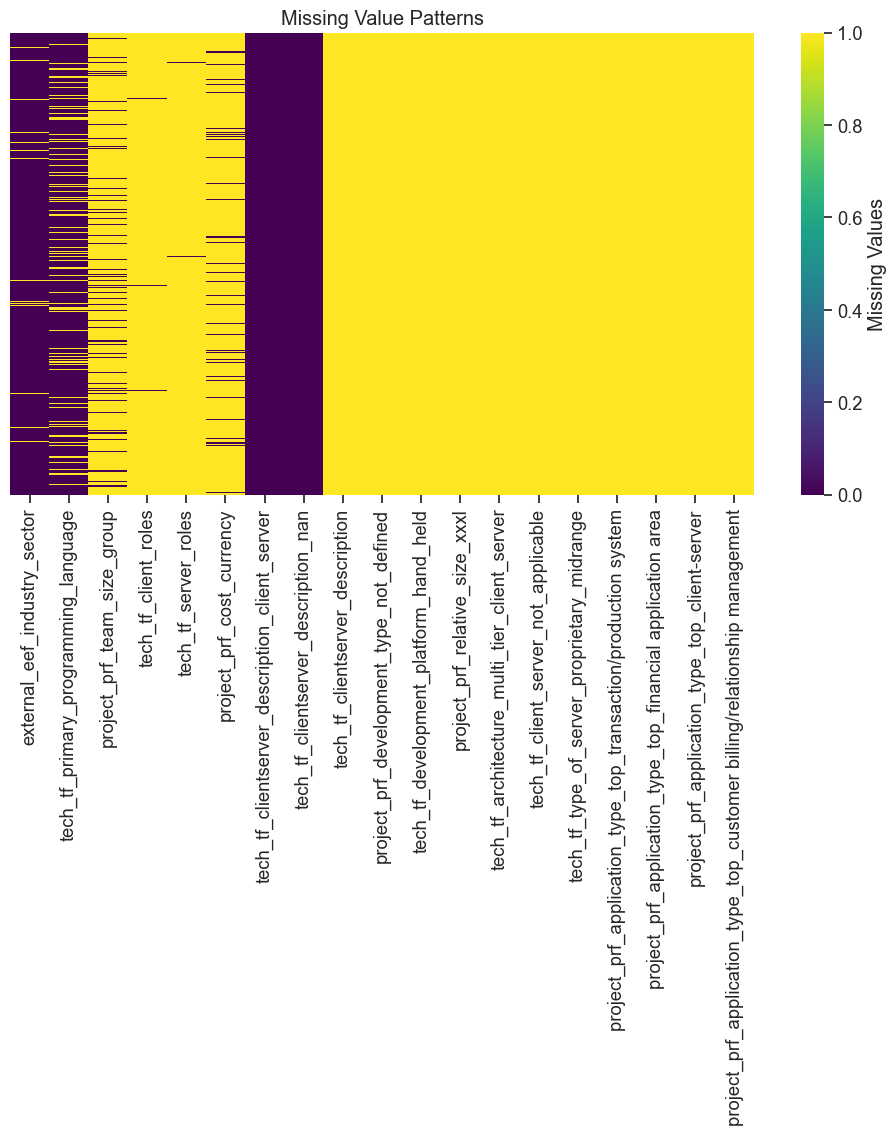

## Categorical Features

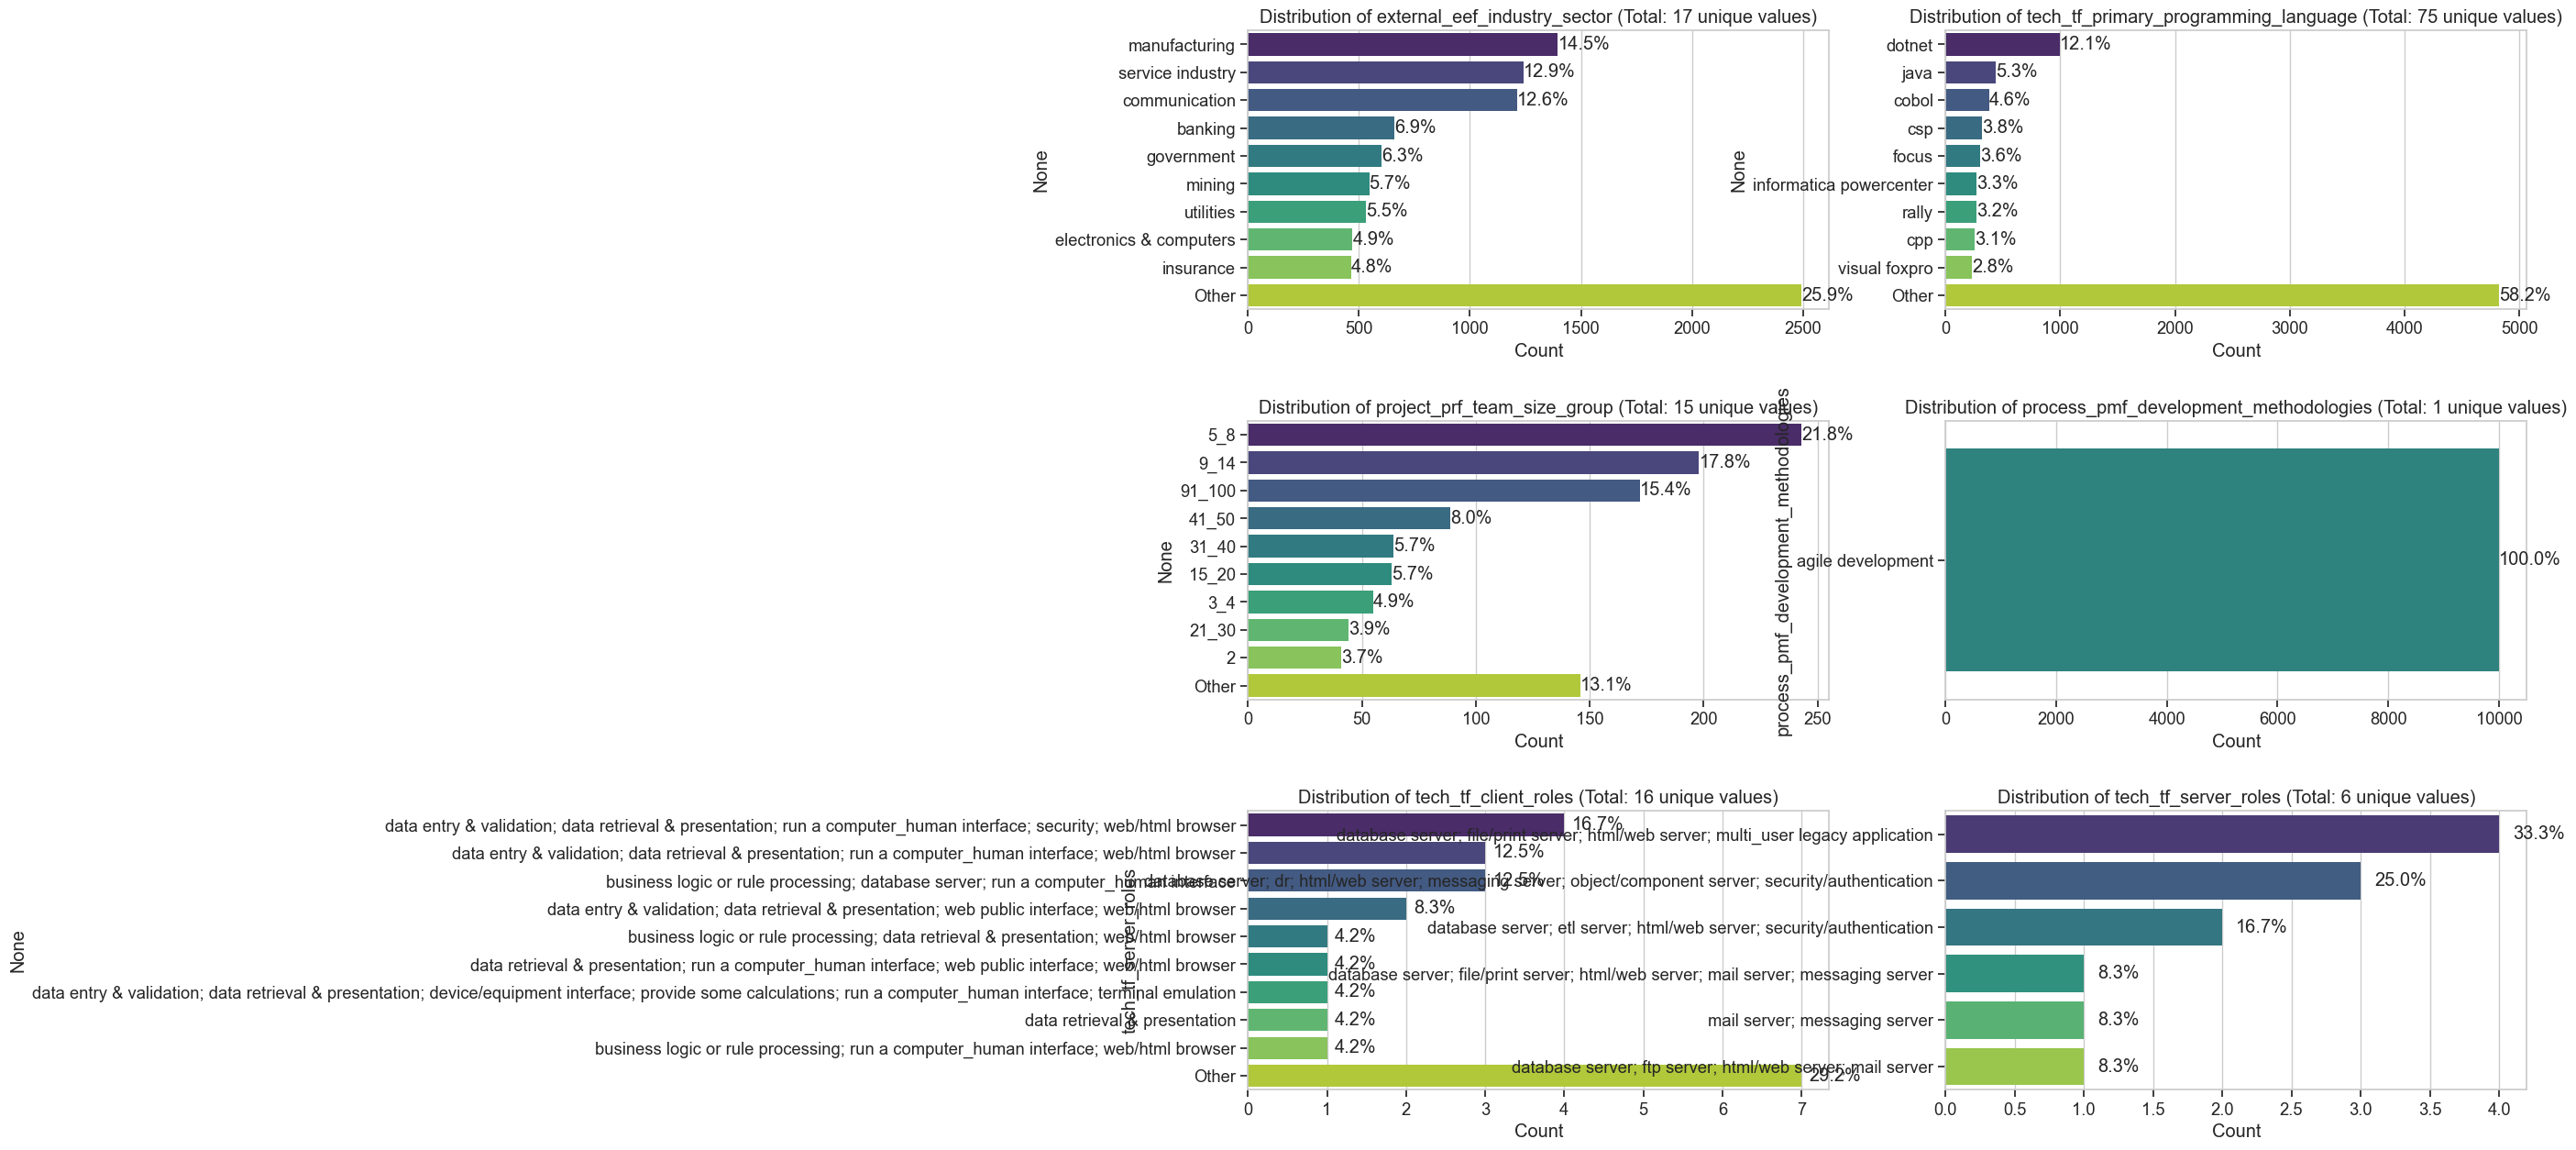

In [9]:
# Exploratory Data Analysis
explore_data(synthetic_data)



[Back to top](#Index:)

<a id='end'></a>

## End